In [28]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [31]:
DATA_STORE = '/Users/Massimiliano/assets.h5'

In [32]:
START = 2000
END = 2018

In [70]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['Market Cap', 'IPO Year' , 'Sector']]

SyntaxError: invalid syntax (3118949611.py, line 5)

In [34]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [35]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, AACG to ZYXI
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  4302 non-null   float64
 1   IPO Year    2622 non-null   float64
 2   Sector      4184 non-null   object 
dtypes: float64(2), object(1)
memory usage: 134.8+ KB


In [36]:
#Remove stocks duplicates and align index names for later joining.
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

#Get tickers with both price information and metadata
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  843 non-null    float64
 1   IPO Year    447 non-null    float64
 2   Sector      836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 26.3+ KB


In [37]:
#resamplemonthlyreturns
monthly_prices = prices.resample('M').last()

In [38]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


In [39]:
#To capture time series dynamics that reflect, for example, momentum patterns, 
#we compute historical returns using the method .pct_change(n_periods), 
#that is, returns over various monthly periods as identified by lags.

#We then convert the wide result back to long format with the .stack() method, 
#use .pipe() to apply the .clip() method to the resulting DataFrame, and 
#Finally, we normalize returns using the geometric average. 
#winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.
#After using .swaplevel() to change the order of the MultiIndex levels, 
#we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [40]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


In [41]:
#Drop stocks with less than 10 yrs of returns

In [42]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [43]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


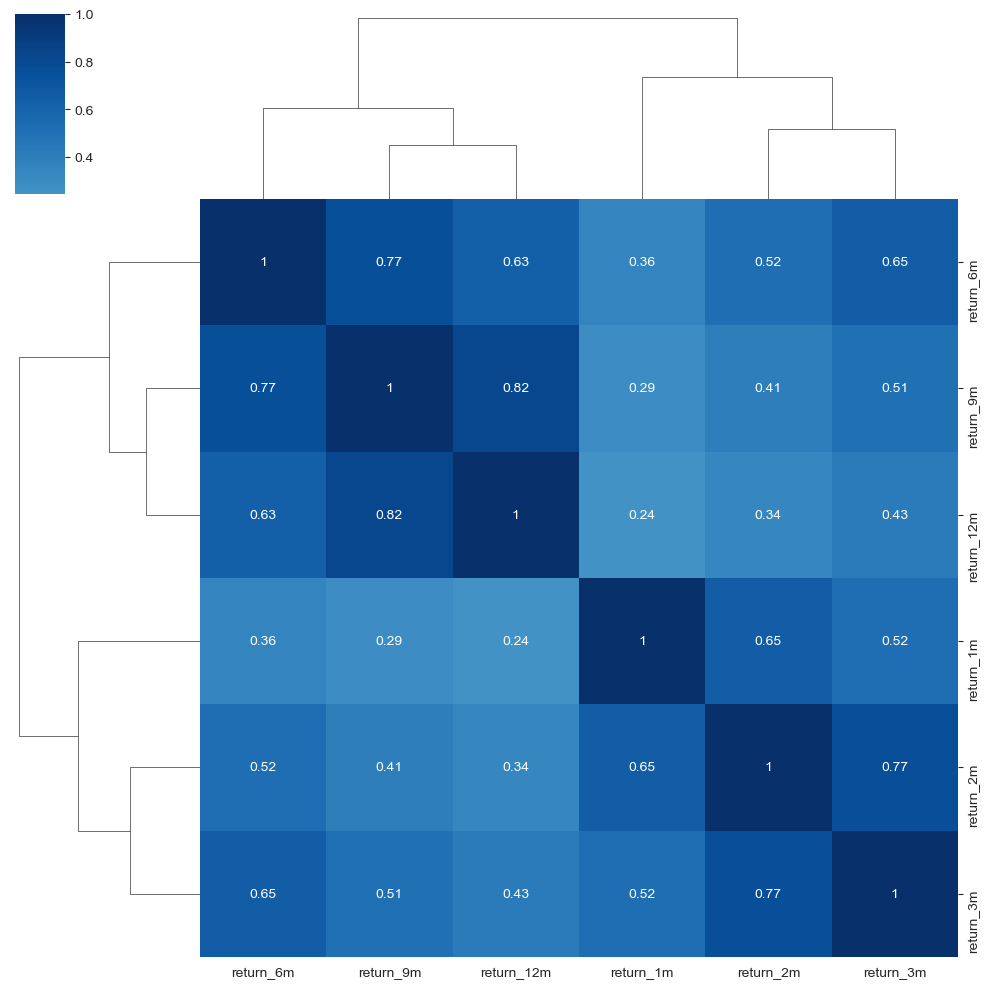

In [44]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [45]:
#n of tickers left
data.index.get_level_values('ticker').nunique()

2385

In [46]:
#the five Fama—French factors, namely market risk, size, value, operating profitability,
# and investment have been shown empirically to explain asset returns and are commonly used 
# to assess the risk/return profile of portfolios. Hence, it is natural to include past 
# factor exposures as financial features in models that aim to predict future returns.We can access 
# the historical factor returns using the pandas-datareader and estimate historical exposures 
# using the RollingOLS rolling linear regression functionality in the statsmodels library as follows:
# Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to 
# the 5 factors market risk, size, value, operating profitability and investment.

In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 283 entries, 2000-01-31 to 2023-07-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  283 non-null    float64
 1   SMB     283 non-null    float64
 2   HML     283 non-null    float64
 3   RMW     283 non-null    float64
 4   CMA     283 non-null    float64
dtypes: float64(5)
memory usage: 13.3 KB


In [48]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     465935 non-null  float64
 1   SMB        465935 non-null  float64
 2   HML        465935 non-null  float64
 3   RMW        465935 non-null  float64
 4   CMA        465935 non-null  float64
 5   return_1m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [49]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [50]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,4.110800e+05,411080.000000,465935.000000
mean,0.973492,0.636987,0.114794,-9.588593e-02,0.011020,1.447280
std,0.950564,1.299703,1.665761,1.970651e+00,2.250540,3.417199
min,-9.839232,-10.501530,-15.440012,-2.388501e+01,-20.177240,-34.475140
25%,0.429052,-0.118705,-0.727252,-1.038744e+00,-1.110432,0.000000
50%,0.918570,0.541603,0.073721,2.814603e-15,0.017130,1.123828
75%,1.458601,1.331325,0.948263,9.435047e-01,1.153548,3.149559
max,10.965766,10.437477,16.273464,1.894054e+01,21.483337,39.249219


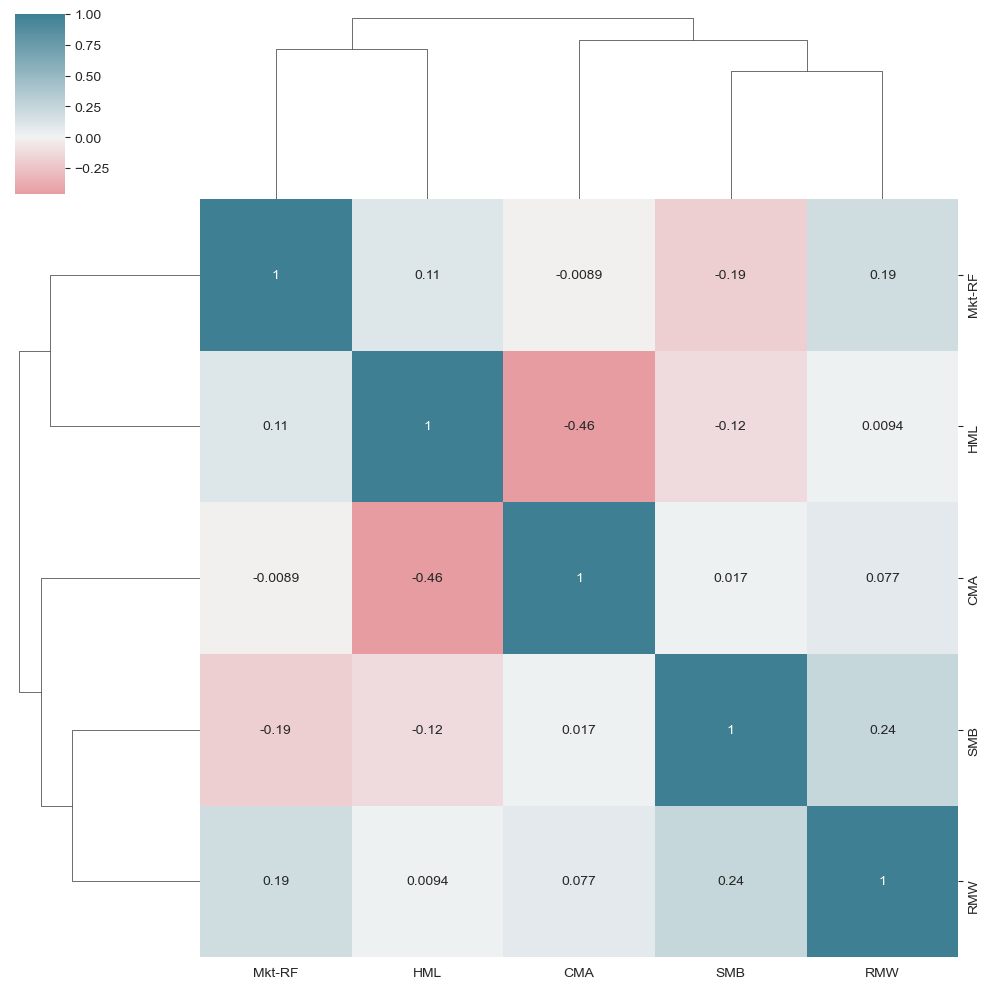

In [51]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [52]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      408695 non-null  float64
 7   SMB         408695 non-null  float64
 8   HML         408695 non-null  float64
 9   RMW         408695 non-null  float64
 10  CMA         408695 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [55]:
data.loc[:, factors] = data.groupby('ticker')[factors].transform(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      465935 non-null  float64
 7   SMB         465935 non-null  float64
 8   HML         465935 non-null  float64
 9   RMW         465935 non-null  float64
 10  CMA         465935 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


In [56]:
#We can use these results to compute momentum factors based on the difference between 
# returns over longer periods and the most recent monthly return, as well as for 
# the difference between 3 and 12 month returns as follows:

In [58]:
for lag in [2,3,6,9,12]:
        data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
        data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [59]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [60]:
#Lagged returns
#To use lagged values as input variables or features associated with the current observations, 
#we use the .shift() method to move historical returns up to the current period:

In [61]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [62]:
#Target: Holding Period Returns
#Similarly, to compute returns for various holding periods, we use the normalized period returns 
# computed previously and shift them back to align them with the current financial features

In [63]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [64]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         465935 non-null  float64
 7   SMB            465935 non-null  float64
 8   HML            465935 non-null  float64
 9   RMW            465935 non-null  float64
 10  CMA            465935 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3_12  465935 non-null  float64
 13  momentum_3     465935 non-null  float64
 14  momentum_6     465935 non-null  float64
 15  momentum_9     465935 non-null  float64
 16  

In [66]:
#Create age proxy
#We use quintiles of IPO year as a proxy for company age.

In [71]:
data = (data
        .join(pd.qcut(stocks['IPO Year'], q=5, labels=list(range(1, 6)))
            .astype(float)
            .fillna(0)
            .astype(int)
            .to_frame('age')))
data.age = data.age.fillna(-1)

In [72]:
#Create dynamic size proxy
#We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [73]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  843 non-null    float64
 1   IPO Year    447 non-null    float64
 2   Sector      836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 58.6+ KB


In [74]:
#Market cap information is tied to currrent prices. We create an adjustment factor 
#to have the values reflect lower historical prices for each individual stock:

In [75]:
size_factor = (monthly_prices
            .loc[data.index.get_level_values('date').unique(),
            data.index.get_level_values('ticker').unique()]
            .sort_index(ascending=False)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 2385 entries, A to ZUMZ
dtypes: float64(2385)
memory usage: 3.8 MB


In [78]:
msize = (size_factor
        .mul(stocks
                .loc[size_factor.columns, 'Market Cap'])).dropna(axis=1, how='all')

KeyError: "['A', 'AAN', 'AAP', 'AAWW', 'ABAX', 'ABC', 'ABCO', 'ABFS', 'ABG', 'ABM', 'ABMD', 'ABT', 'ACAS', 'ACAT', 'ACC', 'ACCL', 'ACCO', 'ACE', 'ACFN', 'ACHN', 'ACI', 'ACN', 'ACO', 'ACXM', 'ADC', 'ADM', 'ADS', 'ADVS', 'AE', 'AEC', 'AEE', 'AEGN', 'AEL', 'AEO', 'AEPI', 'AES', 'AET', 'AF', 'AFAM', 'AFFX', 'AFG', 'AFL', 'AFOP', 'AFSI', 'AGCO', 'AGII', 'AGM', 'AGN', 'AGO', 'AGX', 'AHL', 'AHS', 'AHT', 'AI', 'AIG', 'AIMC', 'AIN', 'AINV', 'AIQ', 'AIR', 'AIRM', 'AIT', 'AIV', 'AIZ', 'AJG', 'AKR', 'AKRX', 'AKS', 'ALB', 'ALE', 'ALG', 'ALJ', 'ALK', 'ALL', 'ALOG', 'ALR', 'ALX', 'ALXN', 'AMAG', 'AMCC', 'AME', 'AMG', 'AMP', 'AMRI', 'AMSG', 'AMT', 'AMTD', 'AMZG', 'AN', 'ANAD', 'ANAT', 'ANCX', 'ANF', 'ANH', 'ANN', 'ANR', 'ANTM', 'AOI', 'AON', 'AOS', 'AP', 'APAGF', 'APC', 'APD', 'APH', 'APL', 'APOL', 'ARC', 'ARCW', 'ARE', 'ARG', 'ARIA', 'ARII', 'ARNA', 'ARNC', 'ARO', 'ARQL', 'ARRS', 'ARSD', 'ARTC', 'ARUN', 'ARW', 'ASBC', 'ASEI', 'ASGN', 'ASH', 'ASNA', 'ATI', 'ATK', 'ATMI', 'ATML', 'ATNY', 'ATO', 'ATR', 'ATRS', 'ATU', 'ATW', 'AUXL', 'AVA', 'AVB', 'AVD', 'AVNR', 'AVP', 'AVX', 'AVY', 'AWI', 'AWR', 'AXAS', 'AXE', 'AXL', 'AXLL', 'AXP', 'AXS', 'AYI', 'AYR', 'AZO', 'AZZ', 'B', 'BA', 'BABY', 'BAC', 'BANC', 'BAS', 'BAX', 'BBBY', 'BBCN', 'BBG', 'BBNK', 'BBOX', 'BBT', 'BBW', 'BBX', 'BBY', 'BC', 'BCO', 'BCOR', 'BCR', 'BDC', 'BDE', 'BDGE', 'BDN', 'BDSI', 'BDX', 'BEAV', 'BEBE', 'BEE', 'BEN', 'BFS', 'BF_B', 'BG', 'BGCP', 'BGG', 'BH', 'BHB', 'BHE', 'BHI', 'BHLB', 'BID', 'BIG', 'BIO', 'BIRT', 'BK', 'BKD', 'BKE', 'BKH', 'BKMU', 'BKS', 'BKYF', 'BLDR', 'BLK', 'BLL', 'BLT', 'BLX', 'BMI', 'BMS', 'BMTC', 'BMY', 'BNCN', 'BOBE', 'BOFI', 'BOH', 'BONT', 'BP', 'BPFH', 'BPZ', 'BRC', 'BRCD', 'BRCM', 'BREW', 'BRKS', 'BRK_A', 'BRK_B', 'BRO', 'BRS', 'BRT', 'BSTC', 'BSX', 'BTH', 'BTU', 'BTX', 'BWA', 'BWINB', 'BWLD', 'BWS', 'BXC', 'BXP', 'BXS', 'BYD', 'BYI', 'BZH', 'C', 'CA', 'CAB', 'CACB', 'CACI', 'CAG', 'CAH', 'CALD', 'CALL', 'CAM', 'CAS', 'CAT', 'CATO', 'CB', 'CBB', 'CBEY', 'CBG', 'CBI', 'CBK', 'CBL', 'CBM', 'CBR', 'CBS', 'CBST', 'CBT', 'CBU', 'CBZ', 'CCC', 'CCE', 'CCF', 'CCI', 'CCK', 'CCL', 'CCMP', 'CCO', 'CDE', 'CDI', 'CDR', 'CE', 'CEB', 'CECE', 'CELG', 'CERN', 'CETV', 'CF', 'CFI', 'CFNB', 'CFNL', 'CFR', 'CGI', 'CHD', 'CHDX', 'CHE', 'CHFC', 'CHFN', 'CHH', 'CHS', 'CHTP', 'CI', 'CIA', 'CIDM', 'CIEN', 'CIFC', 'CIR', 'CIX', 'CKEC', 'CKH', 'CKP', 'CL', 'CLC', 'CLCT', 'CLF', 'CLGX', 'CLH', 'CLI', 'CLMS', 'CLUB', 'CLX', 'CMA', 'CMC', 'CMCSK', 'CMG', 'CMI', 'CMN', 'CMO', 'CMP', 'CMS', 'CNA', 'CNBC', 'CNBKA', 'CNC', 'CNL', 'CNMD', 'CNO', 'CNP', 'CNQR', 'CNS', 'CNVR', 'CNW', 'CNX', 'COB', 'COBZ', 'COF', 'COG', 'COH', 'COHR', 'COL', 'COO', 'COP', 'CORE', 'CORR', 'COWN', 'CPA', 'CPB', 'CPE', 'CPF', 'CPHD', 'CPK', 'CPLA', 'CPST', 'CPT', 'CPWR', 'CQB', 'CR', 'CRAY', 'CRD_B', 'CREE', 'CRI', 'CRK', 'CRL', 'CRM', 'CRR', 'CRRC', 'CRRS', 'CRS', 'CRWN', 'CRY', 'CRZO', 'CSBK', 'CSC', 'CSCD', 'CSE', 'CSFL', 'CSH', 'CSII', 'CSL', 'CSS', 'CSU', 'CSV', 'CTB', 'CTIC', 'CTL', 'CTO', 'CTRX', 'CTS', 'CTWS', 'CTXS', 'CUB', 'CUBE', 'CUI', 'CUNB', 'CUR', 'CUZ', 'CVA', 'CVC', 'CVD', 'CVG', 'CVO', 'CVS', 'CVX', 'CW', 'CWEI', 'CWT', 'CXW', 'CY', 'CYBX', 'CYH', 'CYNO', 'CYTR', 'CYTX', 'D', 'DAR', 'DBD', 'DCI', 'DCO', 'DCT', 'DD', 'DDD', 'DDR', 'DDS', 'DE', 'DECK', 'DEI', 'DEL', 'DELL', 'DEPO', 'DEST', 'DF', 'DFZ', 'DGAS', 'DGX', 'DHI', 'DHR', 'DHT', 'DIN', 'DIS', 'DISCA', 'DK', 'DKS', 'DLB', 'DLLR', 'DLR', 'DLX', 'DMND', 'DNB', 'DNDN', 'DNR', 'DO', 'DOV', 'DOW', 'DPZ', 'DRC', 'DRE', 'DRH', 'DRI', 'DRIV', 'DRL', 'DRQ', 'DSCI', 'DSPG', 'DST', 'DSW', 'DTE', 'DTLK', 'DTSI', 'DTV', 'DUK', 'DV', 'DVA', 'DVN', 'DVR', 'DW', 'DWA', 'DX', 'DY', 'DYAX', 'EAT', 'EBF', 'EBS', 'ECL', 'ECOL', 'ED', 'EDE', 'EDIG', 'EDR', 'EE', 'EFII', 'EFX', 'EGN', 'EGOV', 'EGP', 'EGY', 'EIG', 'EIX', 'EL', 'ELGX', 'ELNK', 'ELRC', 'ELS', 'ELX', 'ELY', 'EMC', 'EMCI', 'EME', 'EMN', 'EMR', 'END', 'ENDP', 'ENH', 'ENR', 'ENS', 'ENVE', 'ENZ', 'ENZN', 'EOG', 'EOX', 'EPAY', 'EPIQ', 'EPM', 'EPR', 'EQR', 'EQT', 'EQU', 'EQY', 'ES', 'ESBF', 'ESC', 'ESE', 'ESI', 'ESIO', 'ESL', 'ESRX', 'ESS', 'ESV', 'ETFC', 'ETH', 'ETM', 'ETN', 'ETR', 'EV', 'EVC', 'EVR', 'EW', 'EXAC', 'EXAR', 'EXP', 'EXR', 'F', 'FBC', 'FBP', 'FC', 'FCE_A', 'FCF', 'FCH', 'FCN', 'FCS', 'FCX', 'FDEF', 'FDO', 'FDP', 'FDS', 'FDX', 'FE', 'FEIC', 'FFBH', 'FFG', 'FFKT', 'FHCO', 'FHN', 'FICO', 'FII', 'FINL', 'FIS', 'FISV', 'FIX', 'FL', 'FLIR', 'FLO', 'FLR', 'FLS', 'FMBI', 'FMC', 'FMD', 'FMER', 'FNB', 'FNF', 'FNFG', 'FNHC', 'FNSR', 'FOE', 'FPO', 'FR', 'FRBK', 'FRED', 'FRM', 'FRO', 'FRT', 'FRX', 'FSGI', 'FSP', 'FSS', 'FST', 'FSYS', 'FTI', 'FTK', 'FTR', 'FUL', 'FUR', 'FVE', 'FXCB', 'FXEN', 'GAS', 'GB', 'GBCI', 'GBL', 'GBLI', 'GBNK', 'GBX', 'GCA', 'GCI', 'GCO', 'GD', 'GDP', 'GE', 'GEF', 'GEO', 'GES', 'GFF', 'GFIG', 'GFN', 'GGG', 'GGP', 'GHC', 'GHDX', 'GHL', 'GHM', 'GIS', 'GK', 'GLF', 'GLT', 'GLUU', 'GLW', 'GMCR', 'GME', 'GMO', 'GMT', 'GNCMA', 'GNW', 'GOLD', 'GORO', 'GPC', 'GPI', 'GPK', 'GPN', 'GPOR', 'GPS', 'GPT', 'GPX', 'GRA', 'GRC', 'GRIF', 'GRMN', 'GRT', 'GS', 'GSIG', 'GSOL', 'GST', 'GTI', 'GTIV', 'GTLS', 'GTN', 'GTT', 'GTXI', 'GTY', 'GUID', 'GVA', 'GWR', 'GWW', 'GXP', 'GY', 'HAE', 'HAL', 'HAR', 'HBHC', 'HBI', 'HCBK', 'HCC', 'HCN', 'HD', 'HDNG', 'HE', 'HEI', 'HEOP', 'HERO', 'HES', 'HF', 'HFC', 'HGR', 'HIG', 'HIL', 'HILL', 'HITK', 'HITT', 'HIW', 'HK', 'HL', 'HLF', 'HLS', 'HLX', 'HME', 'HMN', 'HMPR', 'HMSY', 'HNH', 'HNI', 'HNR', 'HNT', 'HOG', 'HOMB', 'HOS', 'HOT', 'HOV', 'HP', 'HPQ', 'HPT', 'HPY', 'HR', 'HRB', 'HRC', 'HRG', 'HRL', 'HRS', 'HSC', 'HSH', 'HSP', 'HSY', 'HT', 'HTCH', 'HTCO', 'HTGC', 'HTH', 'HUB_B', 'HUM', 'HUN', 'HVB', 'HVT', 'HW', 'HWAY', 'HWCC', 'HXL', 'HZO', 'IACI', 'IBCA', 'IBKC', 'IBM', 'ICE', 'ICGE', 'ICON', 'IDA', 'IDIX', 'IDRA', 'IDT', 'IDTI', 'IEX', 'IFF', 'IG', 'IGT', 'IGTE', 'IHC', 'IHS', 'IIIN', 'IIVI', 'IM', 'IMMU', 'IMN', 'INAP', 'INFA', 'INGR', 'ININ', 'INSY', 'INT', 'INTL', 'INTX', 'INWK', 'IO', 'IP', 'IPCC', 'IPG', 'IPHS', 'IPXL', 'IR', 'IRC', 'IRET', 'IRF', 'IRM', 'ISBC', 'ISCA', 'ISH', 'ISIL', 'ISIS', 'ISLE', 'ISSI', 'IT', 'ITC', 'ITG', 'ITMN', 'ITT', 'ITW', 'IVC', 'IVZ', 'IXYS', 'JAH', 'JBL', 'JCI', 'JCOM', 'JCP', 'JDSU', 'JEC', 'JLL', 'JMBA', 'JNJ', 'JNPR', 'JNS', 'JNY', 'JOE', 'JOY', 'JPM', 'JRN', 'JWN', 'JW_A', 'K', 'KAI', 'KAMN', 'KBALB', 'KBH', 'KBR', 'KCLI', 'KEG', 'KEM', 'KERX', 'KEX', 'KEY', 'KFY', 'KIM', 'KKD', 'KMB', 'KMG', 'KMPR', 'KMT', 'KMX', 'KND', 'KNL', 'KNX', 'KO', 'KOG', 'KOP', 'KR', 'KRC', 'KRG', 'KRO', 'KS', 'KSS', 'KSU', 'KWK', 'KWR', 'L', 'LABL', 'LAD', 'LAYN', 'LAZ', 'LB', 'LBY', 'LCI', 'LDL', 'LDOS', 'LDR', 'LEG', 'LEN', 'LF', 'LG', 'LGF', 'LH', 'LHCG', 'LHO', 'LII', 'LINTA', 'LION', 'LIOX', 'LLL', 'LLTC', 'LLY', 'LM', 'LMIA', 'LMNX', 'LMT', 'LNC', 'LNCE', 'LNDC', 'LNG', 'LNN', 'LORL', 'LOV', 'LOW', 'LPNT', 'LPX', 'LSI', 'LTC', 'LTM', 'LTS', 'LTXC', 'LUB', 'LUK', 'LUV', 'LVLT', 'LVS', 'LXK', 'LXP', 'LXU', 'LYV', 'LZB', 'M', 'MA', 'MAA', 'MAC', 'MAN', 'MANT', 'MAS', 'MATX', 'MBFI', 'MBI', 'MBRG', 'MBVT', 'MCD', 'MCF', 'MCGC', 'MCK', 'MCO', 'MCRL', 'MCRS', 'MCS', 'MCY', 'MD', 'MDC', 'MDCA', 'MDCI', 'MDCO', 'MDP', 'MDR', 'MDT', 'MDU', 'MDVN', 'MEAS', 'MED', 'MEG', 'MEI', 'MENT', 'MET', 'METR', 'MFA', 'MFLX', 'MGI', 'MGLN', 'MGM', 'MHFI', 'MHGC', 'MHK', 'MHO', 'MHR', 'MIG', 'MIL', 'MILL', 'MINI', 'MKC', 'MKL', 'MLHR', 'MLI', 'MLM', 'MLNK', 'MLR', 'MMC', 'MMM', 'MMS', 'MNI', 'MNR', 'MNTA', 'MO', 'MOD', 'MOG_A', 'MOH', 'MON', 'MOS', 'MOSY', 'MOV', 'MPW', 'MPX', 'MRGE', 'MRH', 'MRK', 'MRLN', 'MRO', 'MS', 'MSA', 'MSCC', 'MSFG', 'MSI', 'MSL', 'MSM', 'MSO', 'MTB', 'MTD', 'MTG', 'MTH', 'MTN', 'MTOR', 'MTRN', 'MTSC', 'MTW', 'MTX', 'MTZ', 'MUR', 'MVC', 'MW', 'MWA', 'MWIV', 'MWV', 'MWW', 'MXIM', 'MXWL', 'MYE', 'MYL', 'NANO', 'NASB', 'NAT', 'NATL', 'NAV', 'NAVB', 'NAVG', 'NBBC', 'NBL', 'NBR', 'NBS', 'NC', 'NCI', 'NCR', 'NCS', 'NE', 'NEE', 'NEM', 'NEU', 'NEWP', 'NEWS', 'NFG', 'NFX', 'NGPC', 'NGS', 'NHC', 'NHI', 'NI', 'NILE', 'NJR', 'NKE', 'NL', 'NLS', 'NLY', 'NM', 'NMRX', 'NNI', 'NNVC', 'NOC', 'NOV', 'NP', 'NPBC', 'NPK', 'NPO', 'NPSP', 'NR', 'NRG', 'NSC', 'NSP', 'NSR', 'NTLS', 'NTRI', 'NU', 'NUAN', 'NUE', 'NUS', 'NUTR', 'NUVA', 'NVR', 'NWBO', 'NWN', 'NWY', 'NX', 'NXTM', 'NYCB', 'NYNY', 'NYT', 'O', 'OC', 'OCLR', 'OCN', 'OCR', 'ODC', 'OEH', 'OFC', 'OFG', 'OGE', 'OGXI', 'OHI', 'OI', 'OII', 'OIS', 'OKE', 'OKSB', 'OLBK', 'OLN', 'OLP', 'OMC', 'OME', 'OMG', 'OMI', 'OMN', 'ONNN', 'ONTY', 'OPLK', 'OPY', 'ORA', 'ORB', 'ORBC', 'ORCL', 'ORI', 'ORIT', 'OSIR', 'OSK', 'OUTR', 'OVTI', 'OXM', 'OXY', 'OZRK', 'PACR', 'PAG', 'PATR', 'PAY', 'PB', 'PBCT', 'PBH', 'PBI', 'PBY', 'PCBK', 'PCCC', 'PCG', 'PCL', 'PCLN', 'PCO', 'PCP', 'PCYC', 'PDCE', 'PDLI', 'PEG', 'PEI', 'PEIX', 'PENX', 'PERY', 'PES', 'PETM', 'PFE', 'PFS', 'PG', 'PGI', 'PGNX', 'PGR', 'PGTI', 'PH', 'PHH', 'PHIIK', 'PHM', 'PHMD', 'PHX', 'PICO', 'PII', 'PIKE', 'PIR', 'PJC', 'PKD', 'PKE', 'PKG', 'PKI', 'PKT', 'PKY', 'PL', 'PLCM', 'PLD', 'PLKI', 'PLT', 'PLXT', 'PMCS', 'PMFG', 'PNC', 'PNK', 'PNM', 'PNR', 'PNRA', 'PNW', 'PNX', 'PNY', 'POL', 'POM', 'POR', 'POWR', 'POZN', 'PPG', 'PPHM', 'PPL', 'PPS', 'PQ', 'PRA', 'PRGO', 'PRGX', 'PRK', 'PRKR', 'PRSC', 'PRU', 'PRXL', 'PSA', 'PSB', 'PSEM', 'PSTB', 'PSUN', 'PTIE', 'PTP', 'PTRY', 'PTX', 'PVA', 'PVH', 'PVTB', 'PWR', 'PX', 'PXD', 'PZG', 'QCOR', 'QGEN', 'QLGC', 'QLTY', 'QSII', 'QTM', 'R', 'RAD', 'RAI', 'RAS', 'RAVN', 'RBC', 'RCII', 'RCKB', 'RCL', 'RDC', 'RDEN', 'RDN', 'RE', 'RECN', 'REIS', 'RES', 'REV', 'REX', 'REXI', 'RF', 'RFMD', 'RGR', 'RGS', 'RHI', 'RHP', 'RHT', 'RIG', 'RJET', 'RJF', 'RKT', 'RL', 'RLI', 'RMD', 'RNR', 'RNWK', 'ROC', 'ROG', 'ROIAK', 'ROK', 'ROL', 'ROLL', 'ROVI', 'RPM', 'RPT', 'RPTP', 'RRC', 'RRD', 'RS', 'RSG', 'RSH', 'RSO', 'RSTI', 'RSYS', 'RT', 'RTEC', 'RTI', 'RTIX', 'RTK', 'RTN', 'RUTH', 'RVBD', 'RVLT', 'RWT', 'RYL', 'RYN', 'S', 'SAAS', 'SAFM', 'SAH', 'SAM', 'SAPE', 'SBH', 'SBNY', 'SCBT', 'SCCO', 'SCG', 'SCHN', 'SCHW', 'SCI', 'SCL', 'SCLN', 'SCS', 'SCSS', 'SDRL', 'SE', 'SEAC', 'SEB', 'SEE', 'SF', 'SFG', 'SFL', 'SFLY', 'SFY', 'SGI', 'SGK', 'SGMS', 'SGY', 'SHLD', 'SHLM', 'SHLO', 'SHO', 'SHW', 'SIAL', 'SIF', 'SIG', 'SIGM', 'SIMG', 'SIRO', 'SIVB', 'SJI', 'SJM', 'SJW', 'SKT', 'SKX', 'SLB', 'SLG', 'SLGN', 'SLXP', 'SM', 'SMA', 'SMG', 'SMP', 'SMRT', 'SNA', 'SNAK', 'SNBC', 'SNDK', 'SNH', 'SNHY', 'SNMX', 'SNSS', 'SNTA', 'SNV', 'SNX', 'SO', 'SON', 'SONC', 'SONS', 'SPA', 'SPAR', 'SPDC', 'SPF', 'SPG', 'SPLS', 'SPN', 'SPNC', 'SPPI', 'SPR', 'SPRT', 'SPW', 'SQBG', 'SQNM', 'SRE', 'SRI', 'SSD', 'SSI', 'SSS', 'STAR', 'STC', 'STE', 'STFC', 'STI', 'STJ', 'STL', 'STMP', 'STNR', 'STR', 'STRZA', 'STSA', 'STSI', 'STT', 'STZ', 'SUBK', 'SUI', 'SUNE', 'SUP', 'SUPX', 'SUSQ', 'SUSS', 'SVU', 'SWC', 'SWHC', 'SWK', 'SWM', 'SWN', 'SWS', 'SWX', 'SWY', 'SXI', 'SXT', 'SYK', 'SYKE', 'SYMC', 'SYNT', 'SYUT', 'SYX', 'SYY', 'T', 'TAM', 'TAP', 'TASR', 'TAXI', 'TAYC', 'TBI', 'TCAP', 'TCB', 'TCO', 'TDG', 'TDS', 'TDW', 'TDY', 'TE', 'TEAR', 'TECD', 'TECUA', 'TEG', 'TEN', 'TESO', 'TESS', 'TEX', 'TFX', 'TG', 'TGE', 'TGI', 'TGNA', 'TGT', 'THC', 'THG', 'THLD', 'THO', 'THOR', 'THS', 'TIBX', 'TICC', 'TIF', 'TIS', 'TISI', 'TIVO', 'TJX', 'TK', 'TKR', 'TMK', 'TMO', 'TMP', 'TNC', 'TOL', 'TPC', 'TPLM', 'TPX', 'TQNT', 'TR', 'TRAK', 'TRC', 'TREC', 'TREX', 'TRGT', 'TRI', 'TRK', 'TRN', 'TRR', 'TRV', 'TRW', 'TRXC', 'TSN', 'TSO', 'TSRA', 'TSS', 'TSYS', 'TTC', 'TTI', 'TUES', 'TUP', 'TWC', 'TWER', 'TWGP', 'TWI', 'TWMC', 'TWTC', 'TWX', 'TXI', 'TXT', 'TYC', 'TYL', 'UAA', 'UACL', 'UAM', 'UBA', 'UBNK', 'UBSH', 'UCFC', 'UDR', 'UFI', 'UFS', 'UGI', 'UHAL', 'UHS', 'UHT', 'UIL', 'UIS', 'ULTI', 'ULTR', 'UMH', 'UMPQ', 'UNF', 'UNFI', 'UNH', 'UNM', 'UNP', 'UNS', 'UNT', 'UNTD', 'UNXL', 'UPIP', 'UPL', 'UPS', 'URI', 'URS', 'USAK', 'USB', 'USG', 'USM', 'USMO', 'USNA', 'USPH', 'USTR', 'UTEK', 'UTI', 'UTIW', 'UTL', 'UTX', 'UVE', 'UVV', 'VAL', 'VAR', 'VASC', 'VDSI', 'VFC', 'VG', 'VGR', 'VHC', 'VIAB', 'VIAS', 'VICL', 'VIVO', 'VLCCF', 'VLO', 'VMC', 'VMI', 'VNO', 'VOCS', 'VOLC', 'VPFG', 'VPRT', 'VRX', 'VSH', 'VTR', 'VTSS', 'VVC', 'VVI', 'VVTV', 'VVUS', 'VZ', 'WAB', 'WAC', 'WAG', 'WAL', 'WAT', 'WBCO', 'WBMD', 'WBS', 'WCC', 'WCG', 'WCN', 'WDR', 'WEC', 'WETF', 'WEX', 'WFC', 'WFD', 'WFM', 'WG', 'WGL', 'WGO', 'WHG', 'WHR', 'WIBC', 'WIN', 'WLB', 'WLK', 'WLL', 'WLT', 'WM', 'WMAR', 'WMB', 'WMGI', 'WMK', 'WMT', 'WNC', 'WNR', 'WOR', 'WPP', 'WR', 'WRB', 'WRE', 'WRES', 'WRI', 'WSM', 'WSO', 'WST', 'WSTL', 'WTI', 'WTM', 'WTR', 'WTS', 'WTSL', 'WU', 'WWE', 'WWW', 'WWWW', 'WY', 'WYN', 'X', 'XCO', 'XCRA', 'XEC', 'XL', 'XLNX', 'XNPT', 'XOM', 'XOXO', 'XPO', 'XRM', 'XXIA', 'Y', 'YHOO', 'YRCW', 'YUM', 'ZAZA', 'ZBH', 'ZIGO', 'ZIOP', 'ZIXI', 'ZLC', 'ZMH', 'ZQK'] not in index"